In [0]:
# https://keras.io/
!pip install -q keras
import keras

# 12:54 am 23OCT

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD


from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import keras.callbacks as callbacks
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import numpy as np

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 40 #170  
l = 40
num_filter = 32  # changes filter from 12
compression = 0.5
dropout_rate = 0.2 #0.2

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

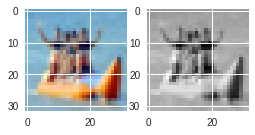

In [0]:
import matplotlib.pyplot as plt

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(x_train)
X_test_gray = grayscale(x_test)

# now we have only one channel in the images
img_channels = 1

# plot a randomly chosen image
img = 92
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(x_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(relu) #mkernel_regularizer=l2(1e-4) changes here
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp
  
x_train.shape

(50000, 32, 32, 3)

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer="he_normal")(relu) # ,kernel_regularizer=l2(1e-4
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
num_filter = 32
dropout_rate = 0.2 #0.2
l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same',kernel_initializer="he_normal")(input) #,kernel_regularizer=l2(1e-4)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# def lr_schedule(epochs):
#     lrate = 0.1
#     if epochs >17:
#       lrate = 0.01
#     elif epochs >= 30:
#       lrate=0.001
#     elif epochs >= 60:
#       lrate=0.0001
#     elif epochs >=80:
#       lrate=0.00001
#     elif epochs >=100:
#       lrate=0.000001
#     elif epochs >=110:
#       lrate=0.0001
#     elif epochs > 125:
#       lrate=0.0000001
# #     elif epochs > 100:
# #       lrate=0.01
      
#     return lrate


def lr_schedule(epochs):
    lrate = 0.1
    if epochs >19:
      lrate = 0.01
    elif epochs >= 30:
      lrate=0.001     
    return lrate

In [0]:
sgd_ = SGD(lr=0.1, momentum=0.9,decay=1e-6, nesterov=True)

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd_,
              metrics=['accuracy'])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
filepath="/content/gdrive/My Drive/Final_version_1_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)

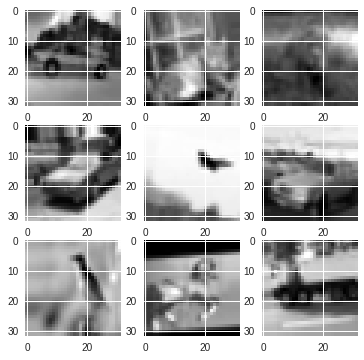

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

# visualize augmented points
plt.figure(figsize=(6, 6))
(X_batch, Y_batch) = datagen.flow(X_train_gray, y_train, batch_size=9).next()
for i in range(9):
    plt.subplot(3, 3, (i + 1))
    plt.imshow(X_batch[i, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [0]:
# (x_train.shape[0] // (batch_size/2))

In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=(x_train.shape[0] // (batch_size/2)), epochs=epochs, verbose=1,
                    validation_data=(x_test,y_test),
                 callbacks=[LearningRateScheduler(lr_schedule),checkpoint])

Epoch 1/40
1562/1562 [==============================] - 529s 339ms/step - loss: 2.2041 - acc: 0.3020 - val_loss: 1.9606 - val_acc: 0.3606

Epoch 00001: val_acc improved from -inf to 0.36060, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-01-0.36.hdf5
Epoch 2/40
1562/1562 [==============================] - 508s 325ms/step - loss: 1.7110 - acc: 0.4232 - val_loss: 1.9539 - val_acc: 0.4044

Epoch 00002: val_acc improved from 0.36060 to 0.40440, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-02-0.40.hdf5
Epoch 3/40
1562/1562 [==============================] - 509s 326ms/step - loss: 1.4193 - acc: 0.5258 - val_loss: 1.7316 - val_acc: 0.4852

Epoch 00003: val_acc improved from 0.40440 to 0.48520, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-03-0.49.hdf5
Epoch 4/40
1562/1562 [==============================] - 511s 327ms/step - loss: 1.2184 - acc: 0.6015 - val_loss: 1.7928 - val_acc: 0.5254

Epoch 00004:

In [0]:
def lr_schedule(epochs):
    lrate = 0.001
    if epochs >19:
      lrate = 0.0001
    elif epochs >= 25:
      lrate=0.001     
    return lrate



In [0]:
model.load_weights('/content/gdrive/My Drive/Final_version_1_weights-improvement-34-0.89.hdf5')


In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=(x_train.shape[0] // (batch_size/2)), epochs=epochs, verbose=1,
                    validation_data=(x_test,y_test),
                 callbacks=[LearningRateScheduler(lr_schedule),checkpoint])

Epoch 1/40
1562/1562 [==============================] - 520s 333ms/step - loss: 0.3551 - acc: 0.9166 - val_loss: 0.4265 - val_acc: 0.9052

Epoch 00001: val_acc improved from -inf to 0.90520, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-01-0.91.hdf5
Epoch 2/40
1562/1562 [==============================] - 503s 322ms/step - loss: 0.3427 - acc: 0.9205 - val_loss: 0.4187 - val_acc: 0.9082

Epoch 00002: val_acc improved from 0.90520 to 0.90820, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-02-0.91.hdf5
Epoch 3/40
1562/1562 [==============================] - 498s 319ms/step - loss: 0.3383 - acc: 0.9214 - val_loss: 0.4262 - val_acc: 0.9066

Epoch 00003: val_acc did not improve from 0.90820
Epoch 4/40
1562/1562 [==============================] - 501s 321ms/step - loss: 0.3341 - acc: 0.9234 - val_loss: 0.4268 - val_acc: 0.9063

Epoch 00004: val_acc did not improve from 0.90820
Epoch 5/40
1562/1562 [==============================] - 4

In [0]:
def lr_schedule(epochs):
    lrate = 0.0001
    if epochs >20:
      lrate = 0.00001
    elif epochs >=35:
      lrate=0.0001     
    return lrate
  
sgd_ = SGD(lr=0.001, momentum=0.9,decay=1e-6, nesterov=True)
  
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd_,
              metrics=['accuracy'])

In [0]:
model.load_weights('/content/gdrive/My Drive/Final_version_1_weights-improvement-40-0.91.hdf5')


In [0]:
history1=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs, verbose=1,
                    validation_data=(x_test,y_test),
                 callbacks=[LearningRateScheduler(step_decay),checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 275s 6ms/step - loss: 0.2515 - acc: 0.9473 - val_loss: 0.3704 - val_acc: 0.9163

Epoch 00001: val_acc improved from -inf to 0.91630, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-01-0.92.hdf5
Epoch 2/40
50000/50000 [==============================] - 266s 5ms/step - loss: 0.2478 - acc: 0.9488 - val_loss: 0.3747 - val_acc: 0.9175

Epoch 00002: val_acc improved from 0.91630 to 0.91750, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-02-0.92.hdf5
Epoch 3/40
50000/50000 [==============================] - 266s 5ms/step - loss: 0.2433 - acc: 0.9504 - val_loss: 0.3744 - val_acc: 0.9184

Epoch 00003: val_acc improved from 0.91750 to 0.91840, saving model to /content/gdrive/My Drive/Final_version_1_weights-improvement-03-0.92.hdf5
Epoch 4/40
50000/50000 [==============================] - 266s 5ms/step - loss: 0.2418 - acc: 0.9510 

In [0]:
model.load_weights('/content/gdrive/My Drive/Final_version_1_weights-improvement-05-0.92.hdf5')

# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 22s 2ms/step
Test loss: 0.36465714502334595
Test accuracy: 0.9223


In [0]:
# history2=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     steps_per_epoch=(x_train.shape[0] // (batch_size/2)), epochs=epochs, verbose=1,
#                     validation_data=(x_test,y_test),
#                  callbacks=[lrate,checkpoint])

In [0]:
# import math

# def step_decay(epoch):
#   initial_lrate = 0.001
#   drop = 0.5
#   epochs_drop = 5.0
#   lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#   return lrate
# lrate = LearningRateScheduler(step_decay)

In [0]:

model.save_weights('model_weights.h5')
weights_file = drive.CreateFile({'Final_version_1' : 'model_weights.h5'})
weights_file.SetContentFile('model_weights.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

GoogleDriveFile({'id': '1Xv--moa1eMaaqWqZhxedQ-H1Lqb85Ako'})